# Legend

### Data
https://files.grouplens.org/datasets/movielens/ml-25m.zip

### Task
Rating prediction for every user

# Imports

In [2]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from funk_svd.utils import _timer
from funk_svd import SVD

In [3]:
sns.set()

# Config

In [7]:
DATA_FOLDER = os.path.join('data', 'ml-25m')
RATINGS_FILENAME = 'ratings.csv'
MOVIES_FILENAME = 'movies.csv'
LINKS_FILENAME = 'links.csv'
TAGS_FILENAME = 'tags.csv'

seed = 0

# Read Data

In [19]:
ratings = pd.read_csv(os.path.join(DATA_FOLDER, RATINGS_FILENAME))

# Reduce Memory Usage

In [20]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [21]:
#ratings.drop('timestamp', axis=1, inplace=True)
ratings['userId'] = pd.to_numeric(ratings['userId'], downcast='integer')
ratings['movieId'] = pd.to_numeric(ratings['movieId'], downcast='integer')
ratings['rating'] = pd.to_numeric(ratings['rating'], downcast='float')

In [22]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int32  
 1   movieId    int32  
 2   rating     float32
 3   timestamp  int64  
dtypes: float32(1), int32(2), int64(1)
memory usage: 476.8 MB


# EDA

In [23]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [14]:
print('Unique users:')
print(ratings['userId'].nunique())

print('Unique movies:')
print(ratings['movieId'].nunique())

print('Ratings count:')
print(ratings.shape[0])

Unique users:
162541
Unique movies:
59047
Ratings count:
25000095


In [15]:
print('Unique ratings:')
print(ratings['rating'].nunique())

Unique ratings:
10


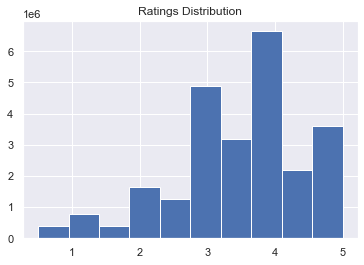

In [16]:
ratings['rating'].hist()
plt.title('Ratings Distribution')
plt.show()

# Funk SVD for rating prediction

## Train Dev Validation Split

In [38]:
@_timer(text='')
def compute_val_test_mask(data, n_rate=4):
    """n_rate last reitings for test"""
    data['rank'] = data.groupby('userId')['timestamp'].rank(method="first", ascending=False)
    return data[data['rank'] <= n_rate].index.tolist()

In [39]:
val_idx = compute_val_test_mask_v2(ratings)

10 sec


In [42]:
ratings.rename({
    'userId': 'u_id',
    'movieId': 'i_id',
}, axis='columns', inplace=True)

In [44]:
train = ratings.drop(val_idx).drop('timestamp', axis=1)
dev = ratings.loc[val_idx].sample(frac=0.5, random_state=0).drop('timestamp', axis=1)
val = ratings.loc[val_idx].drop(dev.index.tolist()).drop('timestamp', axis=1)

## Train Model

In [45]:
svd = SVD(lr=0.001, reg=0.005, n_epochs=100, n_factors=15,
          early_stopping=True, shuffle=False, min_rating=1, max_rating=5)

svd.fit(X=train, X_val=dev)

Preprocessing data...

Preprocessing data...

Epoch 1/100  | val_loss: 0.97 - val_rmse: 0.98 - val_mae: 0.77 - took 2.8 sec
Epoch 2/100  | val_loss: 0.94 - val_rmse: 0.97 - val_mae: 0.75 - took 1.4 sec
Epoch 3/100  | val_loss: 0.92 - val_rmse: 0.96 - val_mae: 0.74 - took 1.4 sec
Epoch 4/100  | val_loss: 0.91 - val_rmse: 0.95 - val_mae: 0.74 - took 1.5 sec
Epoch 5/100  | val_loss: 0.90 - val_rmse: 0.95 - val_mae: 0.73 - took 1.5 sec
Epoch 6/100  | val_loss: 0.89 - val_rmse: 0.95 - val_mae: 0.73 - took 1.5 sec
Epoch 7/100  | val_loss: 0.89 - val_rmse: 0.94 - val_mae: 0.73 - took 1.5 sec
Epoch 8/100  | val_loss: 0.88 - val_rmse: 0.94 - val_mae: 0.72 - took 1.5 sec
Epoch 9/100  | val_loss: 0.88 - val_rmse: 0.94 - val_mae: 0.72 - took 1.4 sec
Epoch 10/100 | val_loss: 0.87 - val_rmse: 0.93 - val_mae: 0.72 - took 1.5 sec
Epoch 11/100 | val_loss: 0.87 - val_rmse: 0.93 - val_mae: 0.72 - took 1.5 sec
Epoch 12/100 | val_loss: 0.87 - val_rmse: 0.93 - val_mae: 0.71 - took 1.5 sec
Epoch 13/100 | val

In [46]:
%%time

pred = svd.predict(val)

rmse = np.sqrt(mean_squared_error(val['rating'], pred))
mae = mean_absolute_error(val['rating'], pred)

print(f'Test RMSE: {rmse:.2f}')
print(f'Test MAE:  {mae:.2f}')
print()

Test RMSE: 0.87
Test MAE:  0.66

Wall time: 1.32 s
